A reconstruction of [1] https://github.com/annkennedy/mushroomBody `getPNdynamics.m` with a learnable parameter.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pickle as pkl

torch.autograd.set_detect_anomaly(False) # helpful for debug

Getting HC data

In [2]:
# Load in data
fp = "hc_data.csv"
df = pd.read_csv(fp)

# get ORN response of a specific odor
odor = 150
ORN_response = df.iloc[odor+1, 2:].astype(float)
ORN_spont = df.iloc[-1, 2:].astype(float)

# removing dm3 for some reason
ORN_response.pop("dm3")
ORN_spont.pop("dm3")

25.0

In [3]:
# time
dt = 5e-4
time = np.arange(-1.5, 0.75, dt)

# odor stimulus
stim_on = 0.0
stim_off = 0.5
stim = np.where((time > stim_on) & (time < stim_off), 1, 0)

# Making ORN data into a time series (NOTE: Potentially unecessary to make a time varying model)
ORN_response = np.repeat(np.array(ORN_response)[:,None], len(time), axis=1)
ORN_spont = np.repeat(np.array(ORN_spont)[:,None], len(time), axis=1)

# Odor time series NOTE: odor is just ORN response, unsure if this is necessary
odor = stim * ORN_response + ORN_spont
ep = 0.0488 # taken from [1]
smooth_odor = np.copy(odor)
for i in range(1,odor.shape[1]):
    smooth_odor[:,i] = ep * odor[:,i] + (1 - ep) * smooth_odor[:,i-1] # exponential smoothing

# time varying variable inititalizatoin
ORN = np.copy(ORN_spont)
LN = np.ones_like(time) * 300
lnr = np.ones_like(time)
inhA = np.ones_like(time) * 50
inhB = np.ones_like(time) * 50

# Converting to pytoch
time = torch.tensor(time)
inhA = torch.tensor(inhA)
inhB = torch.tensor(inhB)
lnr = torch.tensor(lnr)
LN = torch.tensor(LN)
smooth_odor = torch.tensor(smooth_odor)
ORN = torch.tensor(ORN)
ORN_spont = torch.tensor(ORN_spont)

Initializing the model. The model is in pytoch to allow back propogation through time.

In [4]:
class model(torch.nn.Module):
    def __init__(self):
        super(model, self).__init__()
        # set model parameters
        # Learned with least squares with Olsen model
        self.k_1 = 368.6631
        self.k_2 = 31.4088
        self.c = 2.9410
        self.g = 5.3395

        # Set constants
        self.LN_tau_gabaA = 0.1
        self.LN_tau_gabaB = 0.4
        self.ORN_tau = 0.01
        self.PN_tau = 0.01
        self.n = 3
        self.LN_tau = 0.01
        self.LN_thr = 1
        self.LN_inhadd = 200
        self.inh_PN = 0
        self.inh_LN = 0

        # Attempting to learn this param
        LN_inhsc = 200 # normally 500

        # learnable parameter
        self.LN_inhsc = torch.nn.Parameter(torch.tensor(LN_inhsc).float())
        self.LN_inhsc.requires_grad = True

        # relu
        self.relu = torch.nn.ReLU()

    def forward(self, time, dt, inhA, inhB, lnr, LN, smooth_odor, ORN, ORN_spont):
        PN_spont = ORN_spont * self.k_1 / (torch.sum(ORN_spont[:,0]) + self.k_2)
        PN = PN_spont.detach().clone()

        for t, _ in enumerate(time):
            if t == 0:
                continue
            
            # Cloning everything to avoid in place oporation errors
            LN_inhsc = self.LN_inhsc.clone()

            # Gaba A and Gaba B receptor dynamics
            inhA[t] = inhA[t-1] + (-inhA[t-1] + lnr[t-1]) * dt / self.LN_tau_gabaA
            inhB[t] = inhB[t-1] + (-inhB[t-1] + lnr[t-1]) * dt / self.LN_tau_gabaB

            # Neuron dynamics
            ORN[:,t] = ORN[:, t-1] + (-ORN[:,t-1] + smooth_odor[:,t]) * dt / self.ORN_tau
            PN[:,t] = PN[:,t-1] + (
                -PN[:,t-1] + PN_spont[:,t-1] + 200 * torch.tanh((ORN[:,t-1] - ORN_spont[:,t-1] + self.c) * self.g/200 * self.inh_PN)
            ) * dt / self.PN_tau
            PN[:,t] = self.relu(PN[:,t])
            LN[t] = LN[t-1] + (-LN[t-1] + torch.mean(ORN[:,t-1])**self.n * 51/23/2 * self.inh_LN) * dt / self.LN_tau # I don't really know why this is hardcoded
                                                                                                    # after '**n'. in the text it's supposed to be k1' / (k2' + I_ln)
            lnr[t] = (LN[t] - self.LN_thr) * (LN[t] > self.LN_tau)

            # updating gaba inhibition for PNs and LNs
            self.inh_PN =  self.k_1 / (self.k_2 + 0.25 * inhA[t] + 0.75 * inhB[t])
            self.inh_LN = LN_inhsc / (self.LN_inhadd + inhA[t])

        return PN

In [5]:
# The only trainable parameter is LN_inhadd (set to 500 in model)
net = model()
for param in net.parameters():
    print(param)

Parameter containing:
tensor(200., requires_grad=True)


In [6]:
# Load target data
with open("sample_PN.pkl", "rb") as f:
    sample_PN = pkl.load(f)
    sample_PN = torch.tensor(sample_PN)

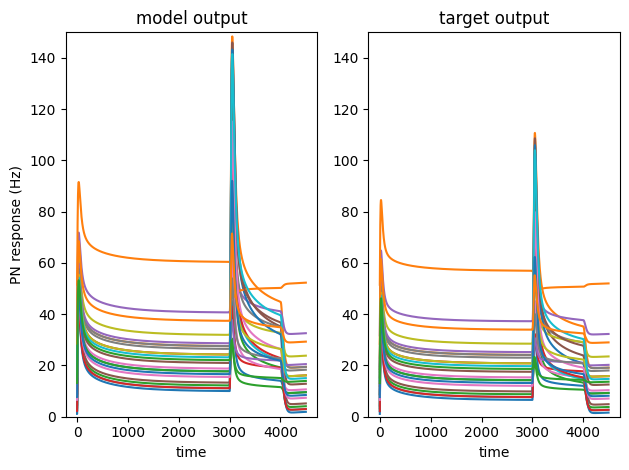

In [7]:
# example output vs sample
# forward model
PN_out = net(time, dt, inhA, inhB, lnr, LN, smooth_odor, ORN, ORN_spont)

# plot
fig, axs = plt.subplots(1, 2)
axs[0].plot(PN_out.detach().numpy().T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("PN response (Hz)")
axs[0].set_title("model output")
axs[0].set_ylim([0, 150])
axs[1].plot(sample_PN.detach().numpy().T)
axs[1].set_xlabel("time")
axs[1].set_title("target output")
axs[1].set_ylim([0, 150])
plt.tight_layout()
plt.show()

Training the model

In [8]:
lr = 100 # high learning rate because weights are high (?)
epochs = 100
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss_list = []
param_list = []

for i in range(epochs):
    # Forward pass and loss
    PN_out = net(time, dt, inhA, inhB, lnr, LN, smooth_odor, ORN, ORN_spont)
    loss = loss_fn(PN_out, sample_PN)

    # recording important variables
    loss_list.append(loss.item())
    for param in net.parameters():
        param_list.append(param.item())

    # Printing out important variables
    print("epoch:", i)
    print("loss:", loss.item())
    print("value of LN_inhsc:", param.item(), "\n")

    # backprop
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

epoch: 0
loss: 38.07248535257312
value of LN_inhsc: 200.0 

epoch: 1
loss: 19.81933377072814
value of LN_inhsc: 249.8385009765625 

epoch: 2
loss: 13.900629587923689
value of LN_inhsc: 276.13653564453125 

epoch: 3
loss: 10.634116794027147
value of LN_inhsc: 295.25384521484375 

epoch: 4
loss: 8.520128223403507
value of LN_inhsc: 310.4598388671875 

epoch: 5
loss: 7.030856831797564
value of LN_inhsc: 323.1324157714844 

epoch: 6
loss: 5.923571588364878
value of LN_inhsc: 334.0059509277344 

epoch: 7
loss: 5.06869549374167
value of LN_inhsc: 343.5255432128906 

epoch: 8
loss: 4.3899890831449975
value of LN_inhsc: 351.9841003417969 

epoch: 9
loss: 3.83937345826507
value of LN_inhsc: 359.58587646484375 

epoch: 10
loss: 3.3848932671400456
value of LN_inhsc: 366.479736328125 

epoch: 11
loss: 3.004427208777513
value of LN_inhsc: 372.77783203125 

epoch: 12
loss: 2.682147128496733
value of LN_inhsc: 378.5669860839844 

epoch: 13
loss: 2.40641531176568
value of LN_inhsc: 383.9159240722656 


Analysis of model training

Text(0, 0.5, 'LN_inhsc')

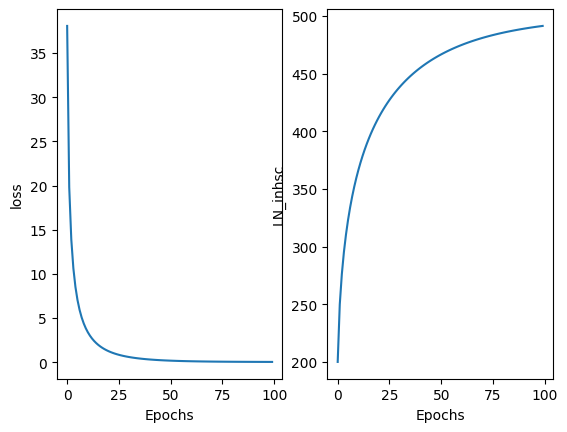

In [9]:
fig, axs = plt.subplots(1,2)
axs[0].plot(range(len(loss_list)), loss_list)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("loss")
axs[1].plot(range(len(param_list)), param_list)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("LN_inhsc")